In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import clear_output

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u
import astropy.coordinates as coord
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.convolution import convolve
from astropy.stats import SigmaClip

from astroquery.vizier import Vizier

from photutils.background import Background2D, MedianBackground
from photutils.utils._parameters import as_pair
from photutils.background import SExtractorBackground
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from photutils.utils import calc_total_error
from photutils.segmentation import SourceCatalog
from photutils.aperture import aperture_photometry
from photutils.aperture import ApertureStats, CircularAperture
from photutils.aperture import CircularAnnulus

In [11]:
import os
dirpath = os.path.dirname(os.path.abspath(__doc__))
filename = "5-test.fits"
path = f'{dirpath}/{filename}'

In [12]:
class Photometry():
    def __init__(self):
        # Setup variables
        self.sigma_background = 1.5 # Detect sources in image based on how many rms
        self.threshold_distance = 1.7 # Remove objects their fwhm are closer than 1.7*fwhm. 1.3 is 3 sigma, 1.7 4 sigma, 2.12 is 5 sigma. 
        self.closest_star_limit = 1 # # Only match stars that are within 1 FWHM_seg.
        self.filter_name = "FILTER" # Filter name in header
        self.gain = "GAIN" # Gain name in header
        self.mjd = "MJD-OBS" # MJD name in header
        self.object = "OBJECT" # name of SN in header
        self.pixel_cut = 100 # remove stars less tahn 100 pixels from the edge
        self.saturation_limit = 10000 # pixel limit for instrument. SOFI is 10000
        
    def get_header(self,img_path):
        """Gives header in fits file
        
        Parameters
        ----------
        img_path : str, path to your image`
        """
        f = fits.open(img_path)
        header = f[0].header
        return header
    
    def get_data(self,img_path):
        """Gives data of fits file
        
        Parameters
        ----------
        img_path : str, path to your image`
        """
        f = fits.open(img_path)
        data = f[0].data
        return data
    
    def get_catalog(self, path):
        """ Returns a astropy.table.table.Table object containing catalog stars using Vizier from,
        image header. For 2MASS, catalog = '2mass'
        
        Parameters (not using in argument, but used below)
        ----------
        catalog : str, name of catalog to use. For near-infrared, use 2mass`
        ra : float, right ascension of SN in degrees`
        dec : float, declination of SN in degrees`
        size: pick catalog stars at a given radius around the SN
        """
        
        header = self.get_header(path)
        ra, dec = header["RA"], header["DEC"]
        size = 4
        catalog = "2mass"
        
        Vizier.ROW_LIMIT = 1000 # maximum number of stars for Vizier,
        result = Vizier.query_region(coord.SkyCoord(ra=ra, dec=dec,
                                                    unit=(u.deg, u.deg),
                                                    frame='icrs'),
                                                    radius=size*u.arcmin,
                                                    catalog=catalog)
        table = result[0]
        cat_df = table.to_pandas()
        # Remove NaNs
        cat_df = cat_df[cat_df["Jmag"].notna()] 
        cat_df = cat_df[cat_df["e_Jmag"].notna()] 
        cat_df = cat_df[cat_df["Hmag"].notna()] 
        cat_df = cat_df[cat_df["e_Hmag"].notna()] 
        cat_df = cat_df[cat_df["Kmag"].notna()] 
        cat_df = cat_df[cat_df["e_Kmag"].notna()] 
        return cat_df
    
    def get_background(self, path, xbox = 50, ybox=50, xfilt=3, yfilt=3):
        """ Creates a Background2D object using a box size (xbox,ybox) and
        a (xfilt,yfilt) median filter. We will estimate the background level in
        each mesh using SExtractorBackground """
        
        sigma_clip = SigmaClip(sigma=3.0)
        image = self.get_data(path)
        bkg_estimator = SExtractorBackground(sigma_clip)
        bkg = Background2D(image, (xbox, ybox), filter_size=(xfilt, yfilt),
                            sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
        clear_output(wait=False)
        return bkg
    
    def make_2dgaussian_kernel(self,fwhm, size, mode='oversample', oversampling=10):
        """
        Make a normalized 2D circular Gaussian kernel. Used to create segmentation image
        """
        ysize, xsize = as_pair('size', size, lower_bound=(0, 1), check_odd=True)

        kernel = Gaussian2DKernel(fwhm * gaussian_fwhm_to_sigma,
                                  x_size=xsize, y_size=ysize, mode=mode,
                                  factor=oversampling)
        kernel.normalize(mode='integral')  # ensure kernel sums to 1
        clear_output(wait=False)
        return kernel   
    
    def convolved_data(self, path):
        """Returns a convolved data object from SUBTRACTED image"""
        #data = self.background_subtraction(img_path)
        data = self.get_data(path)
        # convolve the data with a 2D Gaussian kernel with a FWHM of 3 pixels:
        #from photutils.segmentation import make_2dgaussian_kernel
        kernel = self.make_2dgaussian_kernel(fwhm=5, size=5)  # FWHM = 3.0, size=5 default
        convolved_data = convolve(data, kernel) 
        clear_output(wait=False)
        return convolved_data
    
    def segment_map(self, img_path, npixels=10):
        """Create segment map object"""
        #define the detection threshold
        bkg = self.get_background(path)
        threshold = self.sigma_background * bkg.background_rms # 1.5 default. Make higher to avoid faint objects
        # find sources that have 20 connected pixels that are each greater 
        # than the corresponding pixel-wise threshold,
        convolved_data = self.convolved_data(path)
        #npixels = 20 # npixels in \"segment_map\" and \"deblend_sources\" MUST be the same
        segment_map = detect_sources(convolved_data, threshold, npixels=npixels)
        clear_output(wait=False)
        return segment_map
    
    def segm_deblend(self, path, npixels=10):
        """ Create deblended segmentation image """
        convolved_data = self.convolved_data(path)
        segment_map = self.segment_map(path)
        segm_deblend = deblend_sources(convolved_data, segment_map, npixels=npixels, 
                               nlevels=32, contrast=0.001) # nlevels = 32, contrast=0.001 default,
        clear_output(wait=False)
        return segm_deblend
    
    def segmentation_table(self, path):
        """Get photometry table of the deblended segmentation image. Image MUST be background subtracted"""
        #data = self.background_subtraction(img_path)
        data = self.get_data(path)
        segm_deblend = self.segm_deblend(path)
        convolved_data = self.convolved_data(path)
        bkg = self.get_background(path)
        header = self.get_header(path)
        effective_gain = header[f"{self.gain}"] # 
        error = calc_total_error(data, bkg.background_rms, effective_gain)
        cat = SourceCatalog(data, segm_deblend, convolved_data=convolved_data, error=error,  background=bkg.background)
        table = cat.to_table()
        clear_output(wait=False)
        return table      
    
    def get_fwhm(self, path):
        """Calculate shapes of our segmentation objects"""
        #data = self.background_subtraction(img_path)
        data = self.get_data(path)
        segment_table = self.segmentation_table(path)
        segment_table = segment_table.to_pandas()
        segment_table = segment_table[segment_table["semimajor_sigma"].notna()] 
        segment_table = segment_table[segment_table["semiminor_sigma"].notna()] 
        # Get positions of sources,
        #sources = self.source_detection(img_path=img_path),
        a = segment_table["semimajor_sigma"]
        b = segment_table["semiminor_sigma"]
        fwhm =  2*np.sqrt(np.log(2)*(a**2 + b**2)) 
        # fwhm from https://photutils.readthedocs.io/en/stable/api/photutils.aperture.ApertureStats.html,
        segment_table["fwhm_seg"] = fwhm   
        
        # Remove NaNs
        segment_table = segment_table[segment_table["xcentroid"].notna()] 
        segment_table = segment_table[segment_table["ycentroid"].notna()] 
        segment_table = segment_table[segment_table["fwhm_seg"].notna()] 

        # Extract values from table
        xcentroid = segment_table["xcentroid"]
        ycentroid = segment_table["ycentroid"]
        fwhm = segment_table["fwhm_seg"]

        closest_star_list =  []
        fwhm_ref_list = []
        
        # Calculate distance to closest object in segmentation image
        for i in range(len(segment_table)):
        #i = 0
            xref = xcentroid[i]
            x_remaining = xcentroid.drop(i)

            yref = ycentroid[i]
            y_remaining = ycentroid.drop(i)

            fwhm_ref = fwhm[i]
            fwhm_remaining = fwhm.drop(i)

            xdif = xref - x_remaining
            ydif = yref - y_remaining
            dist = np.sqrt(xdif**2+ydif**2)

            df = pd.DataFrame()
            df["x_remaining"] = x_remaining
            df["y_remaining"] = y_remaining
            df["fwhm_remaining"] = fwhm_remaining
            df["dist"] = dist

            min_dist = min(dist)
            closest_star_list.append(min_dist)

            fwhm_ref = df[df["dist"]==min_dist]
            fwhm_ref = float(fwhm_ref["fwhm_remaining"])
            fwhm_ref_list.append(fwhm_ref)

        segment_table["closest_star"] = closest_star_list
        segment_table["fwhm_ref"] = fwhm_ref_list
        clear_output(wait=False)
        return segment_table
    
    def closest_star(self, path):
        """Match catalog and segmentation image and do photometry"""
        header = self.get_header(path)
        table = self.get_fwhm(path) # load segmentation image 
        # Assuming that most of the flux of the star is within 1.7*fwhm, we require that the stars
        # are a least the sum of their fwhm times 1.7 away from each other        
        table["threshold"] = self.threshold_distance*(table["fwhm_ref"] + table["fwhm_seg"])
        table = table[table["threshold"]<=table["closest_star"]]     
        xpos = table["xcentroid"]
        ypos = table["ycentroid"]

        # Load catalog 
        cat_df = self.get_catalog(path)
        cat_df = cat_df.reset_index()
        cat_ra = np.array(cat_df["RAJ2000"])
        cat_dec = np.array(cat_df["DEJ2000"])
        #cat_id = cat_df["objID"]
        # Convert catalog ra,dec to x,y positions
        c_cat = SkyCoord(ra=cat_ra * u.deg, dec=cat_dec* u.deg, frame='icrs')
        w = WCS(header)
        x_cat, y_cat = w.world_to_pixel(c_cat)

        # Measure difference between catalog position and segmentation position and pick the minimum distance
        star_list = []
        for i in range(len(x_cat)):
            xdif = x_cat[i] - xpos
            ydif = y_cat[i] - ypos
            dist = np.sqrt(xdif**2 + ydif**2)
            table["dist"] = dist

            cat_star = table[table["dist"] == min(table["dist"])]
            cat_star["xcat"] = x_cat[i]
            cat_star["ycat"] = y_cat[i]
            cat_star["RA"] = cat_ra[i]
            cat_star["DEC"] = cat_dec[i]
            #cat_star["cat_id"] = cat_id[i]

            # Add magnitudes to new d             
            cat_star["Jmag"] = cat_df["Jmag"][i]
            cat_star["e_Jmag"] = cat_df["e_Jmag"][i]
            cat_star["Hmag"]  = cat_df["Hmag"][i]
            cat_star["e_Hmag"]  = cat_df["e_Hmag"][i]
            cat_star["Kmag"] = cat_df["Kmag"][i]
            cat_star["e_Kmag"]  = cat_df["e_Kmag"][i]

            star_list.append(cat_star)
        closest_star = pd.concat(star_list) 
        # Only pick stars with smaller distance than closest_star_limit and remove NaNs
        closest_star = closest_star[closest_star["dist"]<=self.closest_star_limit*closest_star["fwhm_seg"]]
        closest_star = closest_star[closest_star["Jmag"].notna()]
        closest_star = closest_star[closest_star["e_Jmag"].notna()]
        closest_star = closest_star[closest_star["Hmag"].notna()]
        closest_star = closest_star[closest_star["e_Hmag"].notna()]
        closest_star = closest_star[closest_star["Kmag"].notna()]
        closest_star = closest_star[closest_star["e_Kmag"].notna()]      
        clear_output(wait=False)    
        return closest_star
    
    def photometry_df(self,path):
        """Creates a dataframe with instrumental magnitudes of the field stars"""
        r_circ_multiplier = 1.7 # We multiply FWHM_seg with this to be within 4 sigma when doing aperture photometry
        r_in_multiplier = 3.6 # radius of inner annulus
        r_out_multiplier = 3.9 # outer annulus
        img_size_multiplier = 0.7 # this is what we multiply r_circular_seg to get image size 
        pixel_cut = self.pixel_cut 
        saturation_limit = self.saturation_limit

        data = self.get_data(path)
        header = self.get_header(path)
        bkg = self.get_background(path)
        background_rms = bkg.background_rms
        phot_list = [] 
        gain = header[f"{self.gain}"]
        closest_star = self.closest_star(path)
        # Remove stars close to the edge, here set to 100 pixels
        xsize = data.shape[1]
        ysize = data.shape[0]
        closest_star = closest_star[pixel_cut<closest_star["xcentroid"]]
        closest_star = closest_star[pixel_cut<closest_star["ycentroid"]]
        closest_star = closest_star[closest_star["xcentroid"]< xsize - pixel_cut]
        closest_star = closest_star[closest_star["ycentroid"]< ysize - pixel_cut]

        #gain = 10
        for i in range(len(closest_star)):    
            # Sometimes we get NaNs from fitting gaussian so we skip these stars
            try: # Sometimes data_star can be empty because size too small. 
                xcat = closest_star.iloc[i]['xcat'] # Notice this will be called "xcenter" in the photometry table!. 
                ycat = closest_star.iloc[i]['ycat'] # This is something that CircularAperture does  
                xcentroid = closest_star.iloc[i]['xcentroid'] # Notice this will be called "xcenter" in the photometry table!. 
                ycentroid = closest_star.iloc[i]['ycentroid'] 

                #positions = (xcentroid, ycentroid)      
                fwhm_seg = closest_star.iloc[i]["fwhm_seg"]
                r_circular_seg = r_circ_multiplier*fwhm_seg
                r_in_seg = r_in_multiplier*fwhm_seg # inner radius annulus
                r_out_seg = r_out_multiplier*fwhm_seg
                img_size = round(img_size_multiplier*r_circular_seg)
                data_star = data[round(ycentroid)-img_size:round(ycentroid)+img_size,
                                 round(xcentroid)-img_size:round(xcentroid)+img_size]
                max_pixel = max(data_star.flatten())

                ### Determine aperture sum from segmentation image  ###
                positions_seg = (round(xcentroid), round(ycentroid))                                
                apertures_seg = CircularAperture(positions_seg, r=r_circular_seg)
                aper_stats_seg = ApertureStats(data, apertures_seg) 
                annulus_aperture_seg = CircularAnnulus(positions_seg, r_in=r_in_seg, r_out=r_out_seg)
                sigclip = SigmaClip(sigma=3.0, maxiters=10)
                bkg_stats_seg = ApertureStats(data, annulus_aperture_seg, sigma_clip=sigclip)
                total_bkg_seg = bkg_stats_seg.median * aper_stats_seg.sum_aper_area.value
                apersum_bkgsub_seg = aper_stats_seg.sum - total_bkg_seg 

                # create phot table
                error = calc_total_error(data, background_rms, gain)  
                phot_table = aperture_photometry(data, apertures_seg, error=error)


                # Create photometry table and add stuff to it 
                phot_table["xcat"] = closest_star.iloc[i]["xcat"]
                phot_table["ycat"] = closest_star.iloc[i]["ycat"]
                phot_table["semimajor_sigma"] = closest_star.iloc[i]["semimajor_sigma"]
                phot_table["semiminor_sigma"] = closest_star.iloc[i]["semiminor_sigma"]
                phot_table["eccentricity"] = np.sqrt((closest_star.iloc[i]["semimajor_sigma"]**2 
                                                      - closest_star.iloc[i]["semiminor_sigma"]**2))/closest_star.iloc[i]["semimajor_sigma"] 
                phot_table["xcentroid"] = closest_star.iloc[i]["xcentroid"]
                phot_table["ycentroid"] = closest_star.iloc[i]["ycentroid"]
                phot_table["RA"] = closest_star.iloc[i]["RA"]
                phot_table["DEC"] = closest_star.iloc[i]["DEC"]
                phot_table["fwhm_seg"] = closest_star.iloc[i]["fwhm_seg"]
                phot_table["max_pixel"] = max_pixel

                ### Add segmentation values ###
                phot_table["r_circular_seg"] = r_circular_seg
                phot_table["r_in_seg"] = r_in_seg
                phot_table["r_out_seg"] = r_out_seg
                phot_table["total_bkg_seg"] = total_bkg_seg
                phot_table["apersum_bkgsub_seg"] = apersum_bkgsub_seg
                phot_table["inst_mag"] =  -2.5*np.log10(apersum_bkgsub_seg)
                phot_table["inst_mag_err"] =  np.abs(-2.5/apersum_bkgsub_seg*np.log(10)) * phot_table["aperture_sum_err"]


                phot_table["Jmag"] = closest_star.iloc[i]["Jmag"]
                phot_table["e_Jmag"] = closest_star.iloc[i]["e_Jmag"]
                phot_table["Hmag"]  = closest_star.iloc[i]["Hmag"]
                phot_table["e_Hmag"]  = closest_star.iloc[i]["e_Hmag"]
                phot_table["Kmag"] = closest_star.iloc[i]["Kmag"]
                phot_table["e_Kmag"]  = closest_star.iloc[i]["e_Kmag"]

                phot_table["MJD-OBS"] =  header["MJD-OBS"]
                phot_table = phot_table.to_pandas()
                phot_list.append(phot_table)


            except ValueError:
                continue
            #except RuntimeError: # Avoids the following error in scipy: 
            #    # Optimal parameters not found: The maximum number of function evaluations is exceeded.
            #    continue
            #except IndexError: # Gaussian fit sometimes fail
            #    continue

        photometry_df =  pd.concat(phot_list)
        # Remove saturated stars for SOFI it is 10000
        df = photometry_df[photometry_df["max_pixel"]<=saturation_limit]
        # Calculate zeropoint
        filt = header[f"{self.filter_name}"] # Filter keyword in header
        df["cat_mag"] = df[f"{filt}mag"]
        df["cat_mag_err"] = df[f"e_{filt}mag"]
        df["zp"] = df["cat_mag"] - df["inst_mag"]
        df["zp_err"] = np.sqrt(df["cat_mag_err"]**2 + df["inst_mag_err"]**2)  
        clear_output(wait=False)    
        return df
    
    def zeropoint(self, path):
        """Calculates the image zeropoint and its error. Here zeropoint is an weighted average"""
        df = self.photometry_df(path)
        zp = np.average(df["zp"],weights=1/df["zp_err"])
        zp_err = np.std(df["zp"])
        return zp, zp_err
    
    def sn_magnitude(self, path):
        """Calculates the apparent magnitude of the supernova. Same code as 
        photometry_df but for the SN only"""
        
        r_circ_multiplier = 1.7
        r_in_multiplier = 3.6
        r_out_multiplier = 3.9
        img_size_multiplier = 0.7
        
        data = self.get_data(path)
        table = self.get_fwhm(path)
        header = self.get_header(path)
        bkg = self.get_background(path)
        background_rms = bkg.background_rms
        sn_ra, sn_dec = header["RA"], header["DEC"]

        gain = header[f"{self.gain}"]
        filt = header[f"{self.filter_name}"]
        c_sn = SkyCoord(ra=sn_ra * u.deg, dec=sn_dec* u.deg, frame='icrs')
        w = WCS(hdr)
        x_sn, y_sn = w.world_to_pixel(c_sn)  
        x_sn, y_sn = float(x_sn), float(y_sn)
        xpos = table["xcentroid"]
        ypos = table["ycentroid"]
        xdif = x_sn - xpos
        ydif = y_sn - ypos
        dist = np.sqrt(xdif**2 + ydif**2)
        #return dist,
        table["dist"] = dist
        cat_star = table[table["dist"] == min(table["dist"])]

        # Only run code if we are able to detect the SN. Usually it should be within 15 pixels of the SN wcs (8 to make sure larger SNe are matched)
        if float(cat_star["dist"]) < 15: 

            fwhm_seg = cat_star["fwhm_seg"]
            xcentroid = round(float(cat_star["xcentroid"]))
            ycentroid = round(float(cat_star["ycentroid"]))
            r_circular_seg = float(r_circ_multiplier*fwhm_seg)
            img_size = round(img_size_multiplier*r_circular_seg)
            fwhm = float(fwhm_seg)
            xfit = xcentroid
            yfit = ycentroid      
            positions = ( round(xfit), round(yfit)) # Aperture center is based on gaussian fit 

            r_circular_seg = r_circ_multiplier*float(fwhm_seg)
            r_in_seg = r_in_multiplier*fwhm # inner radius annulus
            r_out_seg = r_out_multiplier*fwhm

            apertures = CircularAperture(positions, r=r_circular_seg) # don't outcomment this, rest fine
            # Aperture Statistics
            aperstats = ApertureStats(data, apertures) # don't outcomment this
            # Annulus aperture
            annulus_aperture = CircularAnnulus(positions, r_in=r_in_seg, r_out=r_out_seg)
            #  local background level around each source is estimated as the sigma-clipped median
            # value within the circular annulus.
            sigclip = SigmaClip(sigma=3.0, maxiters=10)
            aper_stats = ApertureStats(data, apertures)
            bkg_stats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
            # The total background within the circular apertures is then 
            # the per-pixel background level multiplied by the circular-aperture areas:
            total_bkg = bkg_stats.median * aper_stats.sum_aper_area.value
            # Finally, the local background-subtracted sum within the circular apertures is:
            apersum_bkgsub = aper_stats.sum - total_bkg                    
            # Create photometry table and add stuff to it 
            error = calc_total_error(data=data, bkg_error=background_rms, effective_gain=gain)  
            phot_table = aperture_photometry(data, apertures, error=error) 
            phot_table["xcat"] = x_sn
            phot_table["ycat"] = y_sn
            phot_table["xcentroid"] = xcentroid
            phot_table["ycentroid"] = ycentroid
            phot_table["xcat"] = xfit
            phot_table["ycat"] = yfit
            phot_table["RA"] = sn_ra
            phot_table["DEC"] = sn_dec
            phot_table["fwhm"] = fwhm
            phot_table["r_circular_seg"] = r_circular_seg
            phot_table["r_in_seg"] = r_in_seg
            phot_table["r_out_seg"] = r_out_seg
            phot_table["total_bkg"] = total_bkg
            phot_table["apersum_bkgsub"] = apersum_bkgsub 
            phot_table["inst_mag"] =  -2.5*np.log10(apersum_bkgsub)
            phot_table["inst_mag_err"] =  np.abs(-2.5/apersum_bkgsub) * phot_table["aperture_sum_err"]
            phot_table["filter"] = filt
            phot_table["mjd"] =header[f"{self.mjd}"]
            phot_table["OBJECT"] = hdr[f"{self.object}"]
            
            # Calculate apparent magnitude using zeropoint
            zp, zp_err = self.zeropoint(path)
            phot_table["zp"] = zp 
            phot_table["zp_err"] = zp_err 
            phot_table["apparent_magnitude"] = zp+phot_table["inst_mag"]
            phot_table["apparent_magnitude_err"] = np.sqrt(zp_err**2+phot_table["inst_mag_err"]**2)
            sn_table = phot_table.to_pandas()
            clear_output(wait=False)  
            return sn_table
        

phot = Photometry() # to start the class

# Check supernova position

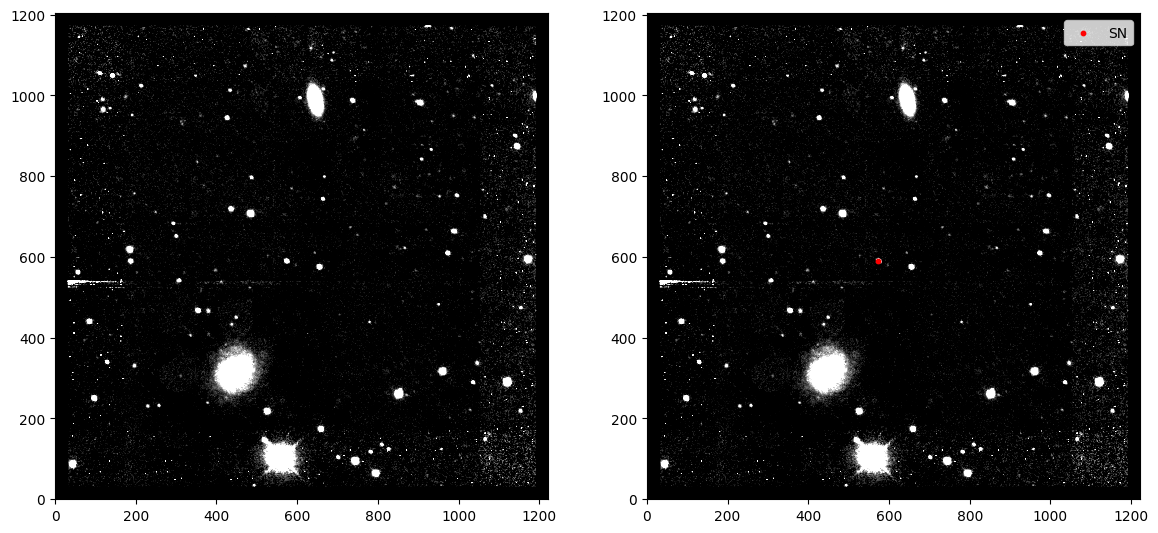

In [13]:
header = phot.get_header(path)
data = phot.get_data(path)
RA,DEC = header["RA"], header["DEC"]
w = WCS(header)
c = SkyCoord(ra=RA * u.deg, dec=DEC* u.deg, frame='icrs')
x, y = w.world_to_pixel(c)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,7))
ax1.imshow(data, cmap='gray', vmin=0.5, vmax=10, origin='lower')
ax2.imshow(data, cmap='gray', vmin=0.5, vmax=10, origin='lower')
ax2.scatter(x,y, label="SN", s=10, c="r")
ax2.legend()
clear_output(wait=False)

# Get catalog and plot catalog stars

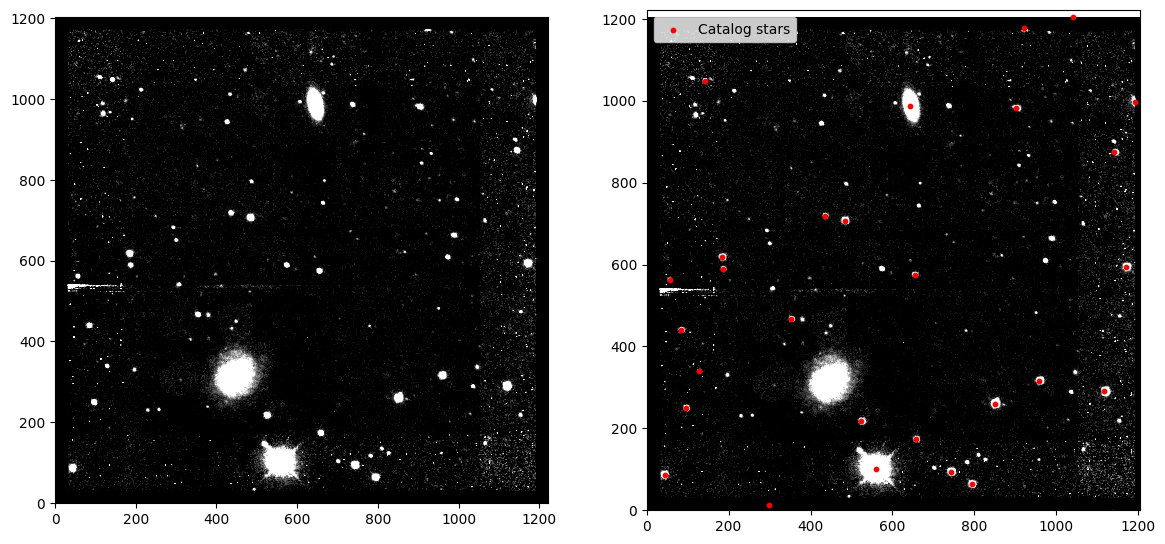

In [14]:
# Download catalog

#cat = phot.get_catalog(catalog="2mass", size=4, ra= RA, dec = DEC)
cat = phot.get_catalog(path)
cat_ra = np.array(cat["RAJ2000"])
cat_dec = np.array(cat["DEJ2000"])
data = phot.get_data(path)

# Load image and calculate catalog star positions
hdr = phot.get_header(path)
w = WCS(hdr)
c_cat = SkyCoord(ra=cat_ra * u.deg, dec=cat_dec* u.deg, frame='icrs')
x_cat, y_cat = w.world_to_pixel(c_cat)
cat["xcat"] = x_cat
cat["ycat"] = y_cat

# Plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,7))
ax1.imshow(data, cmap='gray', vmin=0.5, vmax=10, origin='lower')
ax2.imshow(data, cmap='gray', vmin=0.5, vmax=10, origin='lower')
ax2.scatter(cat["xcat"],cat["ycat"], label="Catalog stars", s=10, c="r")
 # set limit of second plot
yimg = data.shape[1]
ximg = data.shape[0] 
ax2.set_xlim(0,ximg)
ax2.set_ylim(0,yimg)
ax2.legend()
#plt.savefig(f'{path}/catalog_stars.pdf')
# cat.to_csv(f'{path}/catalog_stars.csv')
#plt.close(fig)
clear_output(wait=False)

# Segmentation image

Text(0.5, 1.0, 'Segmentation Image')

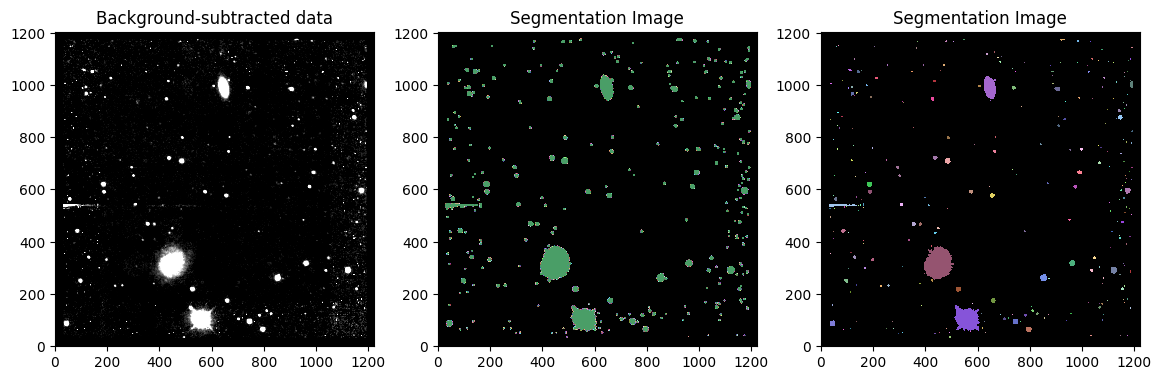

In [15]:
# Taken from https://photutils.readthedocs.io/en/stable/segmentation.html
segm_deblend = phot.segm_deblend(path)

# Plot
data = phot.get_data(path)
segment_map = phot.segment_map(path)
segm_deblend = phot.segm_deblend(path)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 14))
ax1.imshow(data, cmap='gray', vmin=0.5, vmax=10, origin='lower')
ax1.set_title('Background-subtracted data')
ax2.imshow(segment_map, vmin=0.5, vmax=10, origin='lower', cmap=segment_map.cmap)
ax2.set_title('Segmentation Image')
ax3.imshow(segment_map, origin='lower', cmap=segment_map.cmap,
            interpolation='nearest')
ax3.set_title('Segmentation Image')
# Save image
#plt.savefig(f'{path}/segm_deblend.pdf')
#plt.close(fig)

# Match stars and catalog positions

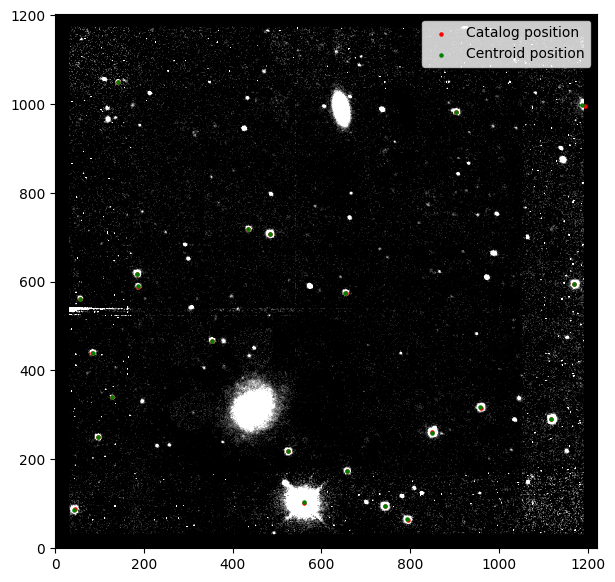

In [16]:
closest_star = phot.closest_star(path)
data = phot.get_data(path)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(data, cmap='gray', vmin=0.5, vmax=10, origin='lower')
ax.scatter(closest_star["xcat"], closest_star["ycat"], label="Catalog position", s=5, c="r")
ax.scatter(closest_star["xcentroid"], closest_star["ycentroid"], label="Centroid position", s=5, c="g")
ax.legend()

# Aperture photometry 

Text(0.5, 1.0, 'Instrumental magnitudes')

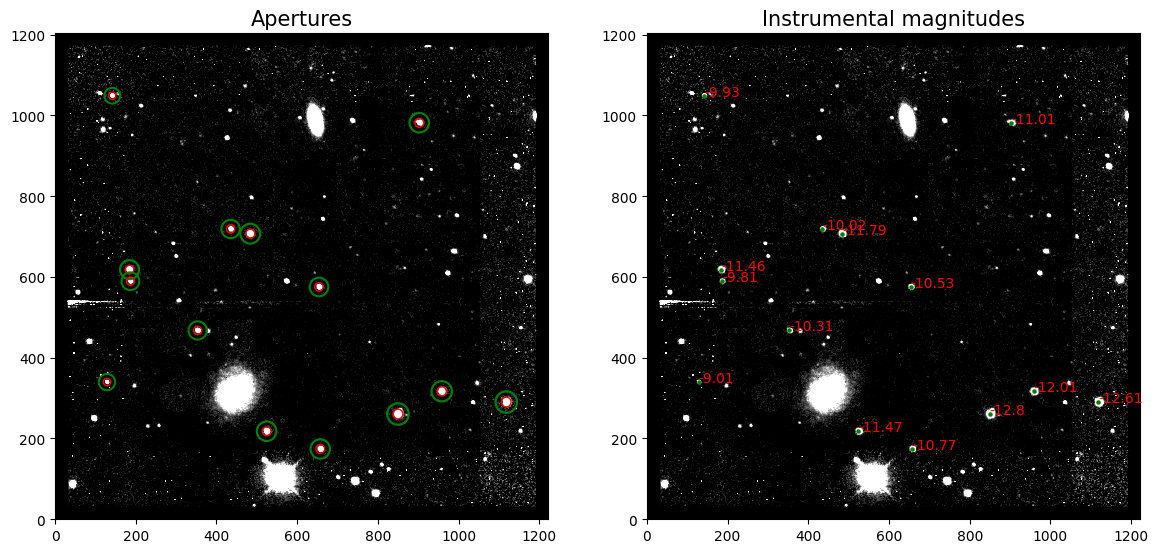

In [17]:
# Plot apertures and magnitudes
df = phot.photometry_df(path)
data = phot.get_data(path)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14, 14))
ax1.imshow(data, cmap='gray', vmin=0.5, vmax=10, origin='lower')
for i in range(len(df)):

    r_circle = plt.Circle((df.iloc[i]['xcentroid'], df.iloc[i]['ycentroid']), df.iloc[i]['r_circular_seg'],
                          fill=False, color='red')
    r_inner = plt.Circle((df.iloc[i]['xcentroid'], df.iloc[i]['ycentroid']), df.iloc[i]["r_in_seg"], fill=False,
                         color='g')
    r_outer = plt.Circle((df.iloc[i]['xcentroid'], df.iloc[i]['ycentroid']), df.iloc[i]["r_out_seg"], fill=False,
                         color='g')

    ax1.add_patch(r_circle)
    ax1.add_patch(r_inner)
    ax1.add_patch(r_outer)
#ax1.legend()
ax1.set_title("Apertures", fontsize=15)
# show names of sne
ax2.imshow(data, cmap='gray', vmin=0.5, vmax=10, origin='lower')
ax2.scatter(df["xcentroid"], df["ycentroid"], label="Centroid position", s=5, c="g")

n = df["inst_mag"]
x = np.array(df["xcentroid"])
y = np.array(df["ycentroid"])
for i, txt in enumerate(n):
    ax2.annotate(round(txt,2), (x[i], y[i]), c="r" )
ax2.set_title("Instrumental magnitudes", fontsize=15)
#plt.savefig(f'{path}/aperture_photometry.pdf')
# df.to_csv(f'{path}/photometry.csv')
#plt.close(fig)

# Calculate supernova magnitude

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/transforms.py:2060: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._mtx[0, 0] *= sx
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/transforms.py:2061: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._mtx[0, 1] *= sx
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/transforms.py:2062: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._mtx[0, 2] *= sx
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/transforms.py:2063: FutureWarning: Calling float on a single element Series

(559.2013421517283, 619.2013421517283)

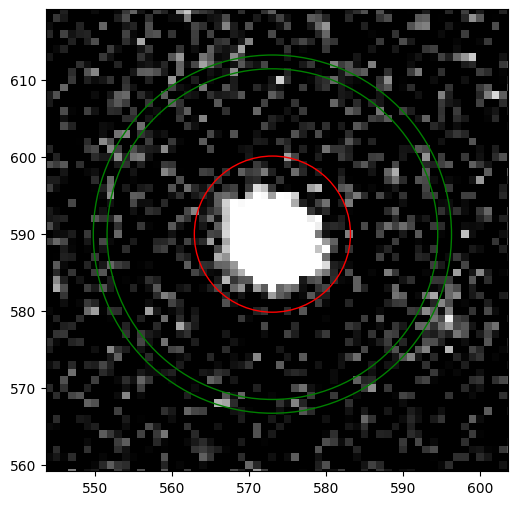

In [18]:
df = phot.sn_magnitude(path)
# Plot SN and its aperture
data = phot.get_data(path)
header = phot.get_header(path)
sn_ra, sn_dec = header["RA"], header["DEC"]
c_sn = SkyCoord(ra=sn_ra * u.deg, dec=sn_dec* u.deg, frame='icrs')
w = WCS(hdr)
x_sn, y_sn = w.world_to_pixel(c_sn)  
x_sn, y_sn = float(x_sn), float(y_sn)

# Plot
ax.set_title("Supernova with annulus")
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(data, cmap='gray', vmin=0.5, vmax=10, origin='lower')

r_circle = plt.Circle((df['xcentroid'], df['ycentroid']), df['r_circular_seg'],
                      fill=False, color='red')
r_inner = plt.Circle((df['xcentroid'], df['ycentroid']), df["r_in_seg"], fill=False,
                     color='g')
r_outer = plt.Circle((df['xcentroid'], df['ycentroid']), df["r_out_seg"], fill=False,
                     color='g')

ax.add_patch(r_circle)
ax.add_patch(r_inner)
ax.add_patch(r_outer)
ax.set_xlim(x_sn-30, x_sn+30)
ax.set_ylim(y_sn-30, y_sn+30)

# df_red = df[["apparent_magnitude","apparent_magnitude_err","mjd","filter"]]
# df_red.to_csv(f'{path}/sn_magnitude.pdf')
#plt.savefig(f'{path}/sn_aperture.pdf')

In [19]:
df

,id,xcenter,ycenter,aperture_sum,aperture_sum_err,xcat,ycat,xcentroid,ycentroid,RA,...,apersum_bkgsub,inst_mag,inst_mag_err,filter,mjd,OBJECT,zp,zp_err,apparent_magnitude,apparent_magnitude_err
0,1,573.0,590.0,9824.94222,60.68422,573.0,590.0,573,590,124.790375,...,9774.098014,-9.975192,0.015522,J,59229.228587,SN2021dn,26.019005,0.125113,16.043813,0.126073


In [10]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1247                                                  
NAXIS2  =                 1238                                                  
ORIGIN  = 'ESO     '           / European Southern Observatory                  
IRAF-TLM= '2013-07-02T15:24:38' / Time of last modification                     
DATE    = '2013-07-02T15:11:40' / UT date when this file was written            
TELESCOP= 'ESO-NTT '           / ESO Telescope Name                             
INSTRUME= 'SOFI    '           / Instrument used.                               
OBJECT  = 'LSQ13fn '           / Original target.                               
RA      =            177.82843 / 11:51:18.82 RA (J2000) pointing (deg)          
DEC     =            -29.605